In [1]:
from flsim.metrics import compute_round_statistics
from matplotlib import pyplot as plt


In [ ]:
results = [
    {"round": 1, "metrics": {"acc": 0.7}, "balances": {1: 5.0, 2: 3.0}},
    {"round": 2, "metrics": {"acc": 0.8}, "balances": {1: 8.0, 2: 5.0}},
]
detection_summary = [
    {"round": 1, "recall": 0.5},
    {"round": 2, "recall": 1.0},
]
stats = compute_round_statistics(results, detection_summary)
stats = {'accuracy_per_round': [(0, 0.689), (1, 0.6861), (2, 0.6892), (3, 0.6761), (4, 0.6918), (5, 0.6852), (6, 0.6872), (7, 0.6921), (8, 0.6987), (9, 0.6918)], 
         'detection_rate_per_round': [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0)], 
         'balances_per_round': [(0, {0: 0.741, 1: 4.748, 2: 2.6950000000000003, 3: 5.396999999999999, 4: 5.18, 5: 2.8649999999999998, 6: 0.833, 7: 4.411, 8: 4.0329999999999995, 9: 0.65}), 
                                (1, {0: 0.741, 1: 9.52, 2: 5.3260000000000005, 3: 10.748999999999999, 4: 10.317, 5: 6.128, 6: 0.833, 7: 8.992999999999999, 8: 8.145999999999999, 9: 0.65}), 
                                (2, {0: 0.741, 1: 28.358390307210083, 2: 16.914236675863194, 3: 51.82890159458094, 4: 30.634292100559385, 5: 18.358369217384222, 6: 0.833, 7: 46.3410692971098, 8: 24.41640729814589, 9: 0.65}), 
                                (3, {0: 0.741, 1: 73.81808359775708, 2: 32.852169963808485, 3: 82.45975723382158, 4: 60.093411421124145, 5: 36.60541910608865, 6: 0.833, 7: 72.05596219674321, 8: 66.18704792345869, 9: 0.65}), 
                                (4, {0: 0.741, 1: 107.94552224688306, 2: 52.593879125133924, 3: 120.75813820680949, 4: 96.90668985125382, 5: 74.9073799684723, 6: 0.833, 7: 103.28242807445585, 8: 95.42442819369516, 9: 0.65}), 
                                (5, {0: 0.741, 1: 146.51125336558673, 2: 89.7748685136346, 3: 164.052798124723, 4: 153.48375411841977, 5: 100.15502962113894, 6: 0.833, 7: 138.49878770463116, 8: 128.5787117445753, 9: 0.65}), 
                                (6, {0: 0.741, 1: 191.22756046825813, 2: 115.13412357858671, 3: 228.82613678205485, 4: 201.80926041729202, 5: 129.05411319202992, 6: 0.833, 7: 193.36331518264365, 8: 166.78351607873267, 9: 0.65}), 
                                (7, {0: 0.741, 1: 248.8656464476362, 2: 139.76109882190406, 3: 277.37910990324553, 4: 248.3447919633217, 5: 157.48476743683216, 6: 0.833, 7: 232.41850115627307, 8: 218.36981196365048, 9: 0.65}), 
                                (8, {0: 0.741, 1: 292.55194476515896, 2: 164.54727409529337, 3: 326.3979996474661, 4: 295.35750451506703, 5: 199.77344285390072, 6: 0.833, 7: 271.04208646141865, 8: 255.77401206099364, 9: 0.65}), 
                                (9, {0: 0.741, 1: 335.73657859507574, 2: 203.02721535364321, 3: 374.7514734229047, 4: 355.76458796861687, 5: 227.6032481418118, 6: 0.833, 7: 309.45467844086625, 8: 292.7453637735181, 9: 0.65})]}

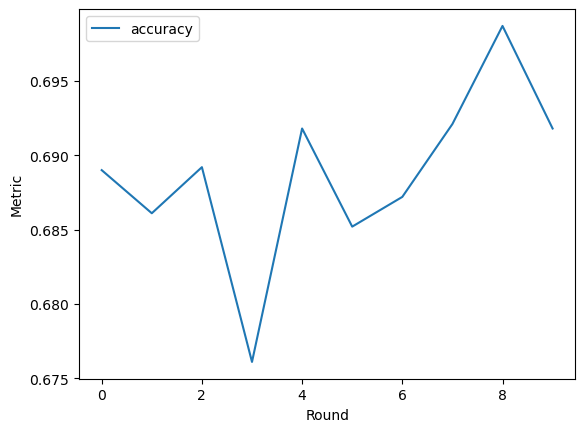

In [8]:
# Plot accuracy and detection rate
rounds_acc, accs = zip(*stats["accuracy_per_round"])
rounds_det, dets = zip(*stats["detection_rate_per_round"])
plt.figure()
plt.plot(rounds_acc, accs, label="accuracy")
# plt.plot(rounds_det, dets, label="detection rate")
plt.xlabel("Round")
plt.ylabel("Metric")
plt.legend()
plt.show()


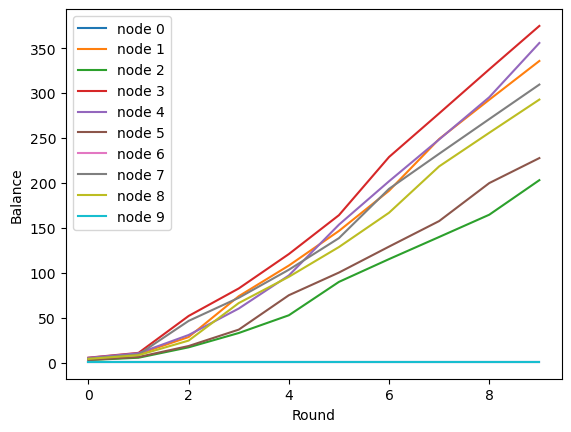

In [9]:
# Plot balances per node
rounds, balances = zip(*stats["balances_per_round"])
nodes = sorted(balances[0].keys())
for node in nodes:
    plt.plot(rounds, [b[node] for b in balances], label=f"node {node}")
plt.xlabel("Round")
plt.ylabel("Balance")
plt.legend()
plt.show()


/Users/yuandouwang/miniconda3/envs/FLSimulation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
usage: ipykernel_launcher.py [-h] --config CONFIG [--dataset DATASET]
                             [--clients CLIENTS] [--iid] [--alpha ALPHA]
                             [--split SPLIT] [--model MODEL] [--epochs EPOCHS]
                             [--batch BATCH] [--lr LR] [--rounds ROUNDS]
                             [--mal-frac MAL_FRAC] [--mal-ids MAL_IDS]
                             [--mal-behavior {scale,signflip,zero,noise}]
                             [--mal-scale MAL_SCALE]
                             [--mal-noise-std MAL_NOISE_STD]
                             [--defense DEFENSE]
ipykernel_launcher.py: error: the following arguments are required: --config


SystemExit: 2

/Users/yuandouwang/miniconda3/envs/FLSimulation/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import numpy as np

def detect_suspicious(node_ids, eval_accs, eval_losses, method="zscore", z_threshold=2.5, iqr_k=1.5):
    accs = np.array(eval_accs)
    losses = np.array(eval_losses)

    suspicious = set()

    if method == "zscore":
        # 计算 Z-score
        z_acc = (accs - accs.mean()) / (accs.std(ddof=0) + 1e-8)
        z_loss = (losses - losses.mean()) / (losses.std(ddof=0) + 1e-8)

        for nid, za, zl in zip(node_ids, z_acc, z_loss):
            if (za < -z_threshold) or (zl > z_threshold):
                suspicious.add(nid)

    elif method == "iqr":
        # 计算 IQR
        def outlier_flags(values, k=iqr_k, tail="both"):
            q1, q3 = np.percentile(values, [25, 75])
            iqr = q3 - q1
            lower, upper = q1 - k * iqr, q3 + k * iqr
            if tail == "low":
                return values < lower
            elif tail == "high":
                return values > upper
            return (values < lower) | (values > upper)

        outliers_acc = outlier_flags(accs, k=iqr_k, tail="low")
        outliers_loss = outlier_flags(losses, k=iqr_k, tail="high")

        for nid, oa, ol in zip(node_ids, outliers_acc, outliers_loss):
            if oa or ol:
                suspicious.add(nid)

    else:
        raise ValueError("method must be 'zscore' or 'iqr'")

    return suspicious


# ================== 使用示例 ==================
node_ids    = [1, 2, 3, 4, 5]
eval_accs   = [0.9, 0.85, 0.1, 0.87, 0.88]   # 某些节点准确率异常低
eval_losses = [0.2, 0.25, 5.0, 0.3, 0.22]    # 某些节点loss异常高

sus_z = detect_suspicious(node_ids, eval_accs, eval_losses, method="zscore", z_threshold=2.0)
print("Suspicious (Z-score):", sus_z)

sus_iqr = detect_suspicious(node_ids, eval_accs, eval_losses, method="iqr", iqr_k=1.5)
print("Suspicious (IQR):", sus_iqr)


Suspicious (Z-score): set()
Suspicious (IQR): {3}
